In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

2022-10-25 00:04:50.994679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 00:04:51.200107: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 00:04:51.896924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-25 00:04:51.897009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
print(os.listdir("image2"))

['sadness', 'anger', 'love', 'fear', 'surprise', 'joy']


In [8]:
images_dir = "image2"
emotion_dirs = os.listdir("image2")
emotion_dirs

['sadness', 'anger', 'love', 'fear', 'surprise', 'joy']

In [19]:
weight = {'anger' : 440, 'fear': 153, 'joy':587, 'love': 650, 'sadness': 758, 'surprise': 457}

In [20]:
sum(weight.values())

3045

NameError: name 'weight' is not defined

In [23]:
class_weights = {}
for i in range(6):
    w = 3045 / (6 * weight[emotion_dirs[i]])
    class_weights[i] = w 
class_weights

{0: 0.6695250659630607,
 1: 1.1534090909090908,
 2: 0.7807692307692308,
 3: 3.316993464052288,
 4: 1.1105032822757113,
 5: 0.8645655877342419}

In [25]:
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = 6

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=emotion_dirs
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=emotion_dirs
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2438 images belonging to 6 classes.
Found 607 images belonging to 6 classes.
Total number of batches = 38 and 9


In [10]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

2022-10-25 00:14:17.604128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 00:14:17.604857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 00:14:17.605442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 00:14:17.606022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 00:14:17.606580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

94765736/94765736 [==============================] - 2s 0us/step


In [11]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [26]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [27]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/tmp/ipykernel_3491763/4005977698.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/20
38/38 [==============================] - 236s 6s/step - loss: 0.3371 - accuracy: 0.9629 - val_loss: 1.8229 - val_accuracy: 0.3837 - lr: 1.0000e-05
Epoch 2/20
38/38 [==============================] - 238s 6s/step - loss: 0.3305 - accuracy: 0.9735 - val_loss: 1.8385 - val_accuracy: 0.3906 - lr: 1.0000e-05
Epoch 3/20
38/38 [==============================] - 241s 6s/step - loss: 0.3228 - accuracy: 0.9718 - val_loss: 1.8232 - val_accuracy: 0.3681 - lr: 1.0000e-05
Epoch 4/20
38/38 [==============================] - 242s 6s/step - loss: 0.3260 - accuracy: 0.9693 - val_loss: 1.7770 - val_accuracy: 0.3924 - lr: 1.0000e-05
Epoch 5/20
38/38 [==============================] - 243s 6s/step - loss: 0.3185 - accuracy: 0.9743 - val_loss: 1.8195 - val_accuracy: 0.3958 - lr: 1.0000e-05
Epoch 6/20
38/38 [==============================] - 250s 6s/step - loss: 0.3091 - accuracy: 0.9762 - val_loss: 1.8000 - val_accuracy: 0.3802 - lr: 1.0000e-05
Epoch 7/20
38/38 [==============================] - 

In [28]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/home/jupyter-k7a506/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_3491763/2442743920.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
38/38 [==============================] - 243s 6s/step - loss: 0.2550 - accuracy: 0.9857 - val_loss: 1.8243 - val_accuracy: 0.3767 - lr: 1.0000e-04
Epoch 2/50
38/38 [==============================] - 241s 6s/step - loss: 0.2299 - accuracy: 0.9874 - val_loss: 1.8322 - val_accuracy: 0.3958 - lr: 1.0000e-04
Epoch 3/50
38/38 [==============================] - 245s 6s/step - loss: 0.2213 - accuracy: 0.9874 - val_loss: 1.8395 - val_accuracy: 0.3733 - lr: 1.0000e-04
Epoch 4/50
38/38 [==============================] - 247s 6s/step - loss: 0.2123 - accuracy: 0.9861 - val_loss: 1.7501 - val_accuracy: 0.4219 - lr: 1.0000e-04
Epoch 5/50
38/38 [==============================] - 248s 6s/step - loss: 0.2067 - accuracy: 0.9882 - val_loss: 1.8418 - val_accuracy: 0.4097 - lr: 1.0000e-04
Epoch 6/50
38/38 [==============================] - 245s 6s/step - loss: 0.2053 - accuracy: 0.9861 - val_loss: 1.8350 - val_accuracy: 0.4080 - lr: 1.0000e-04
Epoch 7/50
38/38 [==============================] - 

In [30]:
model.save('resnet50.h5')
# torch.save(net.state_dict(), 'resnet50_state_dict.pt')

In [38]:
history1.history

{'loss': [0.3371359407901764,
  0.33045342564582825,
  0.32281050086021423,
  0.32597824931144714,
  0.31850939989089966,
  0.3091137111186981,
  0.3103533685207367,
  0.3035227954387665,
  0.30554261803627014,
  0.29435938596725464,
  0.3011374771595001,
  0.30727168917655945,
  0.2962315082550049,
  0.29566049575805664,
  0.2950610816478729,
  0.297534704208374,
  0.29724785685539246,
  0.2973853349685669,
  0.2996280789375305,
  0.293105810880661],
 'accuracy': [0.962931752204895,
  0.9734625220298767,
  0.971777617931366,
  0.9692502021789551,
  0.9743049740791321,
  0.9761512875556946,
  0.978096067905426,
  0.978096067905426,
  0.9768323302268982,
  0.9839932322502136,
  0.9802021980285645,
  0.9738837480545044,
  0.9818871021270752,
  0.9839637875556946,
  0.9831507802009583,
  0.9810446500778198,
  0.9810446500778198,
  0.978096067905426,
  0.978096067905426,
  0.9827295541763306],
 'val_loss': [1.8228590488433838,
  1.8385213613510132,
  1.823171854019165,
  1.776954174041748,

In [39]:
history2.history

{'loss': [0.2550278604030609,
  0.22987721860408783,
  0.22125133872032166,
  0.212260901927948,
  0.20672115683555603,
  0.20530518889427185,
  0.20045098662376404,
  0.19398343563079834,
  0.18583187460899353,
  0.18269285559654236,
  0.18074795603752136,
  0.17925824224948883,
  0.1768510341644287,
  0.1762232482433319,
  0.1807766556739807,
  0.1772855967283249,
  0.17754729092121124,
  0.18053431808948517,
  0.1792164444923401,
  0.17648807168006897,
  0.17774753272533417,
  0.17931796610355377,
  0.17470401525497437,
  0.17836567759513855],
 'accuracy': [0.9856781959533691,
  0.9873631000518799,
  0.9873631000518799,
  0.9860994219779968,
  0.9882055521011353,
  0.9860994219779968,
  0.9856781959533691,
  0.9877843260765076,
  0.9903116822242737,
  0.9903116822242737,
  0.989890456199646,
  0.989890456199646,
  0.9903116822242737,
  0.9894692301750183,
  0.9877843260765076,
  0.9856781959533691,
  0.9882055521011353,
  0.9894692301750183,
  0.9877843260765076,
  0.989048004150390

In [42]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

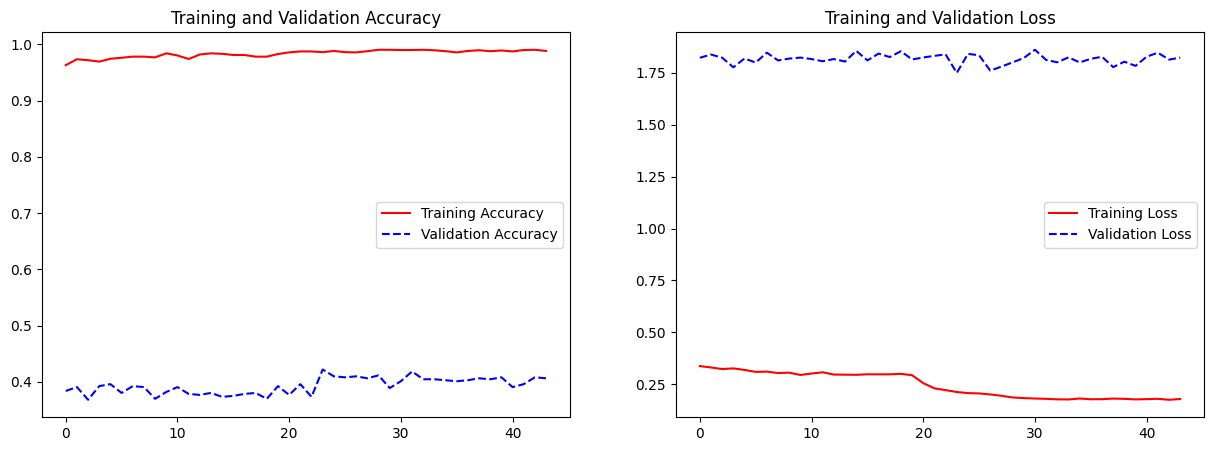

In [43]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

2/2 [==============================] - 2s 566ms/step


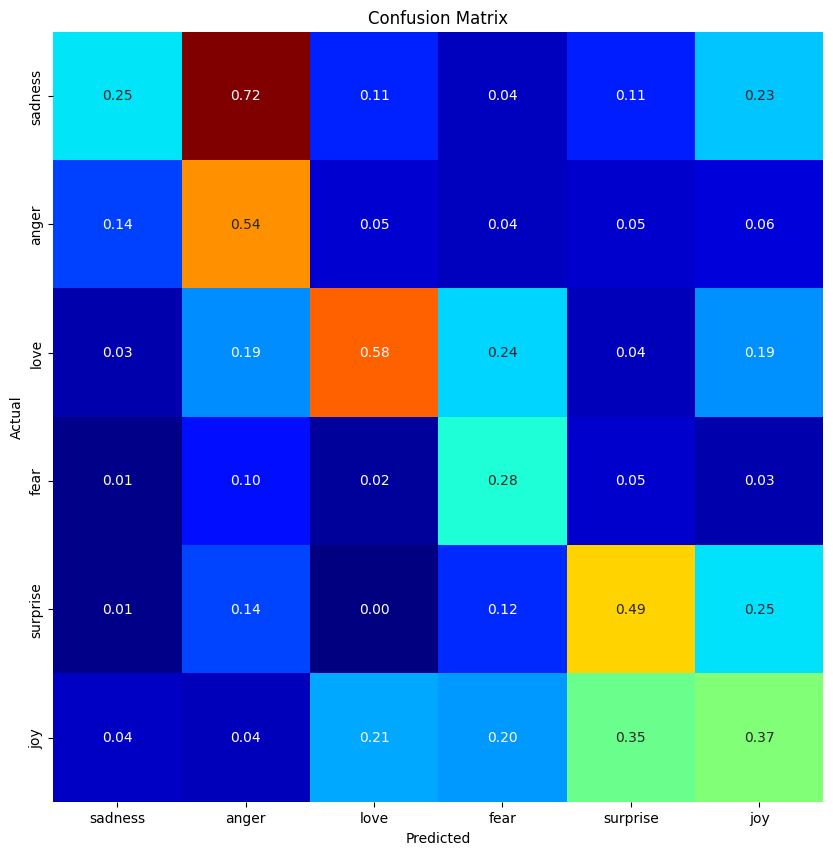

Classification Report:
              precision    recall  f1-score   support

     sadness       0.53      0.25      0.34       139
       anger       0.31      0.54      0.40        79
        love       0.60      0.58      0.59       115
        fear       0.30      0.28      0.29        25
    surprise       0.45      0.49      0.47        81
         joy       0.32      0.37      0.34       104

    accuracy                           0.42       543
   macro avg       0.42      0.42      0.41       543
weighted avg       0.45      0.42      0.42       543



In [52]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = emotion_dirs

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=emotion_dirs))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    transforms.Resize([224,224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=(0.52273315, 0.52848613, 0.5472654), std=(0.21402003, 0.202031, 0.22438332)) # 이미지들의 픽셀 r, g, b의 평균 => 아래 코드에 구하는 부분있으니 참고할 것
])

In [ ]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total

hidden_size = 500 # hidden layer의 노드 개수
num_classes = 6 #  [0,9]까지 class의 개수
num_epochs = 10 # 하단 링크 참조
batch_size = 32 # 하단 링크 참조
num_workers = 1
lr = 1e-3 # learning rate로 backpropagation시 움직이는 스텝의 크기를 결정 

In [5]:
train_data = datasets.ImageFolder(root='./image2/',transform=transform)
train_data

Dataset ImageFolder
    Number of datapoints: 3045
    Root location: ./image2/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Normalize(mean=(0.52273315, 0.52848613, 0.5472654), std=(0.21402003, 0.202031, 0.22438332))
           )

In [8]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2, train_size = 0.8,
                                        random_state=42, shuffle=True, stratify=train_data.targets)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)